# **A Dog and yet a Cat.**

In [18]:
#Automatically reloading
%reload_ext autoreload
%autoreload 2

#inline plotting
%matplotlib inline

In [19]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [20]:
path = 'data/dogscats/'

In [32]:
#Network features
arch = resnet34
sz = 299
bs = 30

In [33]:
torch.cuda.is_available()

True

In [34]:
torch.backends.cudnn.enabled

True

***I/- Enable Data Augmentation and Precompute=True.***

In [35]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_paths(path, tfms=tfms, bs=bs, num_workers=2)
learn = ConvLearner.pretrained(arch, data,  precompute=True, ps=0.5) 

In [36]:
categories = data.classes

In [37]:
categories

['cats', 'dogs']

In [38]:
len(data.trn_ds)

23000

In [39]:
len(data.val_ds)

2000

In [40]:
#for a bs of 30, we have ?? minibatches per 1 epoch
numb_minibatch = len(data.trn_ds)/bs
f"for every epoch the trainer will go through {numb_minibatch}. minibatches of 28 images each."

'for every epoch the trainer will go through 766.6666666666666. minibatches of 28 images each.'

***II/- Find a descent learning rate(lr):  highest lr where the error is still clearly going down.***

In [41]:
lrf = learn.lr_find()

 75%|███████▍  | 574/767 [00:02<00:00, 286.46it/s, loss=0.323]


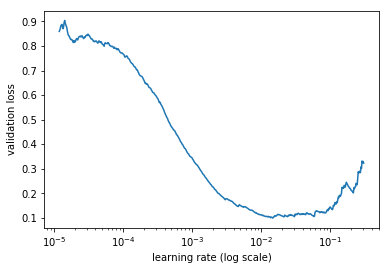

In [42]:
learn.sched.plot()

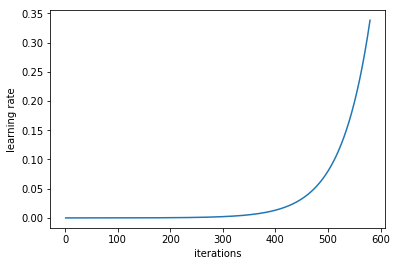

In [43]:
learn.sched.plot_lr()

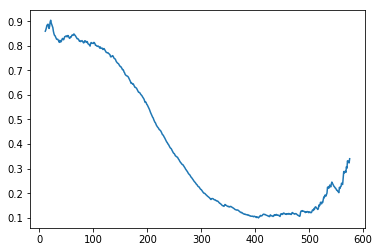

In [44]:
learn.sched.plot_loss()

In [45]:
lr=0.01

***III/ - Train the last layer with precomputed activations for 1 epochs***

In [46]:
#Train the last layers.....with lr=0.001
#learn.fit(lr, 3)
learn.fit(lr, 5, visualize=True)

epoch      trn_loss   val_loss   accuracy   
    0      0.058829   0.020873   0.993     
    1      0.048301   0.022899   0.9915     ▼ △
    2      0.039303   0.022373   0.991      ▼ ▼
    3      0.043703   0.02035    0.9915     △ ▼
    4      0.039283   0.018671   0.9925     ▼ ▼



[array([0.01867]), 0.9924999955296516]

##### *Notes on above accuracy:* 
   - *good news*:  *the model accuracy is improving through epochs*
   - *good news*: *trn_loss (a way of measuring the error of our model) is going down, thus the error on model is getting better.*
   - *bad news*:  *val_loss is not particularly going down through epochs.*
   - *good news*: *the model is not overfitting but it is not really improving (overfitting means trn_loss << val_loss). higher error on trn_set (trn_loss > val_loss) means that we are doing a better job on val_set.*   

***IV/-  Train last layer with data augmentation for 3 epochs with cycle_len=1***

In [47]:
# remove the precomputed activations in order to effectively use data augmentation.   
learn.precompute = False

In [48]:
#Resetting the learning rate after each 'cycle_len' number of epochs  
learn.fit(lr, 3, cycle_len=1, visualize=True)

epoch      trn_loss   val_loss   accuracy   
    0      0.049541   0.018874   0.993     
    1      0.043635   0.02105    0.9925     ▼ △
    2      0.048762   0.019892   0.993      △ ▼



[array([0.01989]), 0.9929999941587448]

In [49]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 299, 299]),
                           ('output_shape', [-1, 64, 150, 150]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 150, 150]),
                           ('output_shape', [-1, 64, 150, 150]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 150, 150]),
                           ('output_shape', [-1, 64, 150, 150]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 150, 150]),
                           ('output_shape', [-1, 64, 75, 75]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 75, 

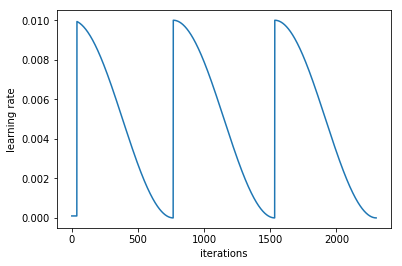

In [50]:
learn.sched.plot_lr()

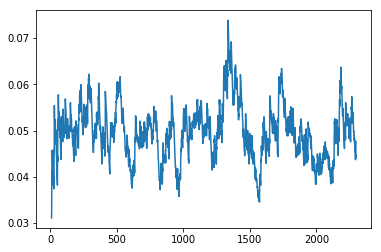

In [51]:
learn.sched.plot_loss()

In [58]:
learn.save('lastlay_rn34_299')

In [59]:
learn.load('lastlay_rn34_299')

***V/ - Unfreeze all layers***

In [54]:
#release other layers to train the whole network...
learn.unfreeze()
#learn.bn_freeze(True)

***VI/ - Set shallow layers to 10 times smaller lr than the next higher layer.***

In [55]:
#Define and apply differential learning rates to the shallow, intermediate and last layers.
lr = 0.01
dlr = np.array([lr/100, lr/10, lr])
dlr

array([0.0001, 0.001 , 0.01  ])

***VII/ - Call lr_find() again after setting the differential learning rate: It is the lr of the last layer which will be printed out !*** 

In [56]:
##lrf = learn.lr_find()

***VIII/   - Train the full network with cycle_mult=2***

In [57]:
learn.fit(dlr, 3, cycle_len=1, visualize=True)

epoch      trn_loss   val_loss   accuracy   
    0      0.044853   0.019536   0.9925    
    1      0.035981   0.017525   0.9935     ▼ ▼
    2      0.042923   0.019764   0.992      △ △



[array([0.01976]), 0.9919999951124191]

In [60]:
learn.save('Allay_rn34_299')

In [61]:
learn.load('Allay_rn34_299')

In [62]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 299, 299]),
                           ('output_shape', [-1, 64, 150, 150]),
                           ('trainable', True),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 150, 150]),
                           ('output_shape', [-1, 64, 150, 150]),
                           ('trainable', True),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 150, 150]),
                           ('output_shape', [-1, 64, 150, 150]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 150, 150]),
                           ('output_shape', [-1, 64, 75, 75]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 75, 75

In [66]:
# Test time augmentation to predict on the original images alongside the augmented images
log_preds , y = learn.TTA()

In [67]:
# Average predictions on the original and augmented images
probs = np.mean(np.exp(log_preds),0)
model_accur = accuracy_np(probs, y)

f"* Model accuracy: {model_accur*100} %"

#print('* Model accuracy: ' + str(model_accuracy * 100) + '%')

'* Model accuracy: 99.45 %'

In [68]:
model_accur

0.9945

In [69]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

### Result overview...

In [73]:
from sklearn.metrics import confusion_matrix

In [74]:
model_cm = confusion_matrix(preds, y)

[[998   9]
 [  2 991]]


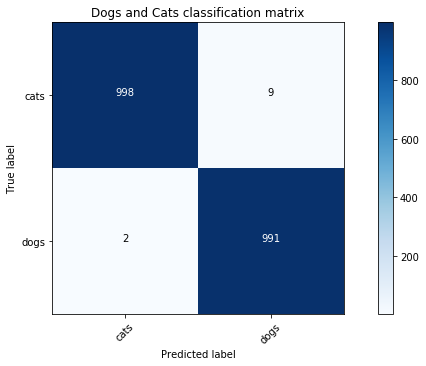

In [76]:
plot_confusion_matrix(model_cm, categories, normalize=False, title='Dogs and Cats classification matrix', figsize=(10, 5))

In [77]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds_da == data.val_y)==is_correct)

In [78]:
def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

In [79]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [82]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

In [85]:
data.classes[0]

'cats'

In [87]:
data.classes[1]

'dogs'

Wrong predicted cats !


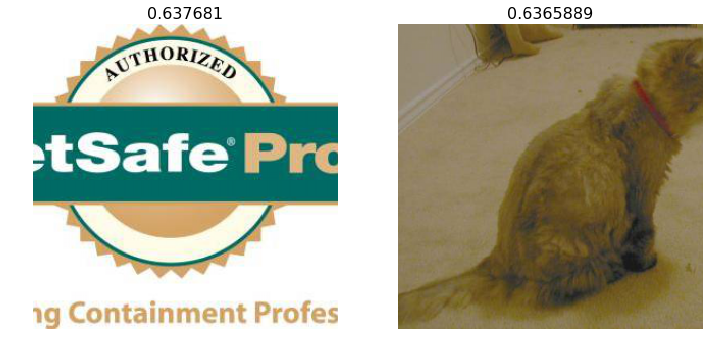

In [88]:
plot_val_with_title(most_by_correct(0, False), title="Wrong predicted cats !")

Wrong predicted dogs !!


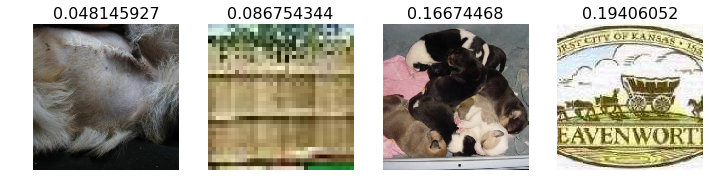

In [98]:
plot_val_with_title(most_by_correct(1, False), title="Wrong predicted dogs !!")

Cats correctly classified


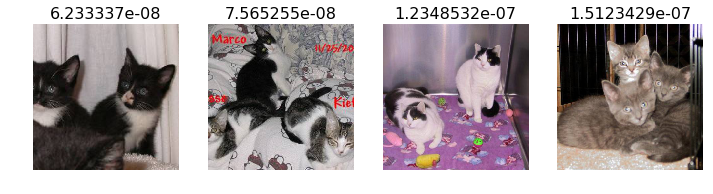

In [99]:
plot_val_with_title(most_by_correct(0, True), title="Cats correctly classified")

Dogs correctly classified !


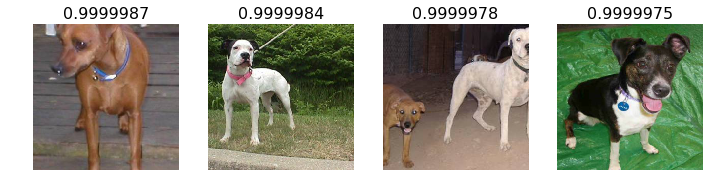

In [100]:
plot_val_with_title(most_by_correct(1, True), title="Dogs correctly classified !")